<a href="https://colab.research.google.com/github/MohammadGhasemiHamed/dreamQuarkTest/blob/main/dreamqaurkTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is the dreamquark test for the emeregency housing problem. The data is available at:  
https://github.com/dreamquark-ai/data-science-test

It is a multi-class (class number is four) classification problem with unbalanced data where the objective is to minimize a cost function that weight the crossentropy with a given confusion matrix.

By analysing the data, we can see that it comes from a temporal data generation function.  This hypothesis is verified by looking at :

* The sum of rejection and admission per day. We have a clear weekly seasonality. With high peak in Monday and large decrease in weekends. The peaks in Mondays and other non-weekend days suggest the hypothesis that the center could have a limited number of place or a limited resource which seams fairly logical. This plot is included in step number zero at the end of this notebook.   

 

* Distribution of daily rejection rates per number of visit (if the current visit is the first one or the second visit and etc. The distribution could also be conditioned by districts and the dependences does not disappear. In both cases, one could observe that these the daily rejection rate is not independent from the visit number. Indeed the data provide strong elements supporting the hypothesis that the rejection rates are influenced by the group history. For sake of brevity the aforementioned grouping is not included here. 

Further, the final classification models put a large weight on temporal variables. Actually, temporal variables are the most impactful variables and this fact are verified in model interpreation part described in step 6. 

The idea behind this work is to extract the temporal relationship and daily saisonality from the data and to encode them into meaningful variables.  

This notebook is organazied as follows :
Steps : 1 to 4 are purely Data preparations. Note that The step number 3 is computationally demanding and would require some hours of computations. This step creates temporal trace for the data. It augments the dataset with additional variables that capture the temporal state of centers and groups.

Step 3 adds two groups of variables :

1.  Variables employed to keep track of persons inside the center : 
```
#['nbPresentDay','nbReservedDay','nbAdmitedDay','nbAdmited1Day','nbAdmited2Day',
#                'nbAdmited3Day','nbRejectCard','nbCurrRejectCard',
#                'nbCurrAdmited','nbCurrAdmited1Day','nbCurrAdmited2Day',
#                'nbCurrAdmited3Day']
```

Note that the variables: 
```
#['nbPresentDay','nbAdmitedDay','nbAdmited1Day','nbAdmited2Day','nbAdmited3Day',#'nbRejectCard']
```
 are the sum of other variables for each day. They also served me for the analysis of daily admisssion and rejection. Besides they are useful for debugging the code. These six grouping variables are all set to zero in step 5. They should be set to zero since they resume the whole day admission flow and should not be accesible during the day. 


2. Varaiables employed to keep track of group history : 
```
# ['grNbAdmited1Day','grNbAdmited2Day','grNbAdmited3Day','grNbAdmitedDay',#'grNbTimeAdmited','grNbRejectCard','grNbDayFromLastReject',#'grNbDayFromLastAdmit','grLastAdmitType1',
#      'grLastAdmitType2','grLastAdmitType3','grLastAdmitTypeNeg'
#      ]





The step 5 prepare the data for classification.  There is no added value to read and undrestand it. Remember that this step set six grouping variables to zero and adding extra information to independent variables. Step 6 performs the classification and model explanation. Step 7 use odd ratios for various classes to undrestand models errors and find  intutions for later treatements.


For the first run, you should begin by 1 and go throught all steps.
Once you have done the step 1 to 3, the datasets are now stored on disk.

So for next runs, you should begin by 2, then perform the step number 4 and continue. Note that the step number 4 reloads the dataset saved in step 3.

This notebook reads and saves Data from the current directory. 

Concerning the source code, step 3 is better documented than the rest.  


### 1-Convert The indviduals dataset, Only Once (skip next time).



In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')
import os

#os.chdir('/content/drive/My Drive/Python/dreamquark/')
os.getcwd()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content/drive/My Drive/Python/dreamquark'

In [2]:
import numpy as np
import pandas as pd
requests_train=pd.read_csv('requests_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv('requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)

requests_train.fillna('nan',inplace=True)

requests_test.fillna('nan',inplace=True)


drop_ind=set(requests_train.district.unique()).difference(set(requests_test.district.unique()))
drop_ind=list(drop_ind)
# training with district 315842
print('removed 1 training obs with district : ',drop_ind)
drop_ind=requests_train.index[requests_train.district.isin(drop_ind)]
requests_train.drop(drop_ind,axis=0,inplace=True)

print(requests_train.shape)

removed 1 training obs with district :  [315842]
(238190, 24)


In [3]:
indv_train=pd.read_csv('individuals_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

indv_test = pd.read_csv('individuals_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)


indv_train.fillna('nan',inplace=True)
indv_test.fillna('nan',inplace=True)

####################
year=2019
indv_train['age']=year-indv_train.birth_year
indv_test['age']=year-indv_test.birth_year

###############


In [5]:
groupCountDF_train=indv_train.groupby('request_id').agg(  
     groupCount=('request_id','count') ,maxAge=('age', 'max'), minAge=('age', 'min'))

######################

groupCountDF_test=indv_test.groupby('request_id').agg(  
     groupCount=('request_id','count') ,maxAge=('age', 'max'), minAge=('age', 'min'))


######
requests_train.index=requests_train.request_id
requests_test.index=requests_test.request_id


joined_train= pd.concat([requests_train, groupCountDF_train], axis=1, sort=False,join='inner')
joined_test= pd.concat([requests_test, groupCountDF_test], axis=1, sort=False,join='inner')



joined_train.to_csv('requests_train_joindGroups.csv',index=False)
joined_test.to_csv('requests_test_joindGroups.csv',index=False)

print('Data saved sucessfully !')

Data saved sucessfully !


### 2- Data cleaning

In [21]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
from  tensorflow.keras.backend import zeros_like,one_hot

  
def keras_competition_loss(y_true, y_pred):
  y_pred=tf.cast(y_pred, tf.float64)
  y_true=y_true.astype(float)


  sample_weight= (10**y_true).astype(float)
  eps=1e-15
  
  #transformed_labels=to_categorical(y_true, num_classes=4)

  transformed_labels=tf.keras.backend.one_hot( y_true, num_classes=4)
  transformed_labels=tf.cast(transformed_labels,tf.float64)


  #print(transformed_labels)

  y_pred= tf.keras.backend.clip(y_pred, eps, 1 - eps)
  y_pred /= tf.reshape(tf.reduce_sum(y_pred,axis=1),[-1,1])
  y_pred_log=tf.cast(tf.math.log(y_pred),tf.float64)

  loss = -tf.reduce_sum(transformed_labels * y_pred_log,axis=1)

  #loss = -tf.reduce_sum(transformed_labels * tf.math.log(y_pred),axis=1)

 
  val=(tf.reduce_sum(loss * sample_weight) / tf.reduce_sum(sample_weight))


  return val


In [22]:
#############Utility functions

from  sklearn.preprocessing import LabelEncoder,OneHotEncoder
#################################

seasons = [4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 1]
month_to_season = dict(zip(range(1,13), seasons))

def date_creation(var_df,date_str,var_str):

  var_lundi=var_df[date_str].apply(lambda k:pd.to_datetime(k).weekday()==0).astype(int)
  var_wknd=var_df[date_str].apply(lambda k:(pd.to_datetime(k).weekday() in [5,6]) ).astype(int)
  var_wd=var_df[date_str].apply(lambda k:pd.to_datetime(k).weekday() in [1,2,3,4] ).astype(int)
  var_day=var_df[date_str].apply(lambda k:pd.to_datetime(k).weekday() ).astype(int)


  var_month=var_df[date_str].apply(lambda k:pd.to_datetime(k).month)
  var_season=var_df[date_str].apply(lambda k:month_to_season[pd.to_datetime(k).month])

  var_hour=var_df[date_str].apply(lambda k:pd.to_datetime(k).hour)
  var_is_night=var_df[date_str].apply(lambda k:pd.to_datetime(k).hour>=20 or pd.to_datetime(k).hour<=6 ).astype(int)
 

  var_all= var_df[date_str].apply(lambda k: int('{}{:02d}{:02d}'.format(pd.to_datetime(k).year,pd.to_datetime(k).month,pd.to_datetime(k).day))  )
   
  var_df=var_df.assign( **{
                (var_str+'_islundi'):var_lundi,
                (var_str+'_isweeknd'):var_wknd,
                (var_str+'_mar2vend'):var_wd,
                (var_str+'_weekday'):var_day

#                ,(var_str+'_month'):var_month,
#                (var_str+'_season'):var_season,
#                (var_str+'_hour'):var_hour,
#                (var_str+'_isnight'):var_is_night,
                ,(var_str+'_all'):var_all
  })
  
  return var_df

#############################################################
col_encoders={};
def label_encoder(col,test=False):
  
  #print(col.name)
  if(test):
    encoder=col_encoders[col.name][0]
  else:
    encoder=LabelEncoder()
    if(col_encoders.get(col.name,-1)==-1):
      col_encoders[col.name]=[encoder];
    else:
      col_encoders[col.name].append([encoder]);

    vals=encoder.fit_transform(col)
 
  return vals

#print(encoder.inverse_transform(vals))
######################################################
### encode variables in listOfVars in dummy vars

def encodeVarsInDummy(currentDF,listOfVars,use_dummiesFor):
  DUMMY_CAT2VEC={}
  for currentCol in listOfVars:
    #print(currentCol)
    if currentCol in use_dummiesFor :
      currentSer=pd.get_dummies(currentDF[currentCol])
      colNames=[ currentCol +'_'+str(name) for name in currentSer.columns];
      #print(colNames)
      currentSer.columns=colNames
      DUMMY_CAT2VEC[currentCol]=list(currentSer.columns)

      currentDF.drop(currentCol,axis=1,inplace=True)
      currentDF[currentSer.columns]=currentSer

    else:
      currentSer=label_encoder(currentDF[currentCol])
      currentDF[currentCol+'_converted']=currentSer

  return currentDF,DUMMY_CAT2VEC;



In [23]:
##### initialising
import os
import numpy as np
import pandas as pd

#os.chdir('/content/drive/My Drive/Python/dreamquark/')
print('current Foler: ',os.getcwd())

use_dummiesFor=['child_to_come','group_type',
                'group_composition_label','housing_situation_label',
                'answer_weekday',
                'long_term_housing_request','requester_type',
                'victim_of_violence_type','victim_of_violence'
                ]

remove_list_beforModel=['district']


#remove_list=['town','district']
remove_list=['town','district','group_composition_id','child_situation','housing_situation_id']
#remove_list=[]


convert_dates=True
reduce_housing_situation_label_dummies=False

requests_train=pd.read_csv('requests_train_joindGroups.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv('requests_test_joindGroups.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)

#######################

requests_train.child_situation=str(requests_train.child_situation)
requests_test.child_situation=str(requests_test.child_situation)

requests_train.district=requests_train.district.apply(str)
requests_test.district=requests_test.district.apply(str)

##############

drop_ind=set(requests_train.district.unique()).difference(set(requests_test.district.unique()))
drop_ind=list(drop_ind)
# training with district 315842
print('removed 1 training obs with district : ',drop_ind)

drop_ind=requests_train.index[requests_train.district.isin(drop_ind)]
requests_train.drop(drop_ind,axis=0,inplace=True)

##########################################

### missing values

#requests_test.apply (lambda k: k.hasnans,axis=0)
#requests_train.fillna('nan',inplace=True)
#requests_test.fillna('nan',inplace=True)



requests_train.child_to_come[requests_train.child_to_come.isna()]='f'
requests_train.housing_situation_label[requests_train.housing_situation_label.isna()]='individual'
requests_train.long_term_housing_request[requests_train.long_term_housing_request.isna()]='nan'
requests_train.town[requests_train.town.isna()]='nan'
requests_train.victim_of_violence_type[requests_train.victim_of_violence_type.isna()]='nan'


requests_test.group_type[requests_test.group_type.isna()]='individual'
requests_test.victim_of_violence[requests_test.victim_of_violence.isna()]='f'
requests_test.group_composition_label[requests_test.group_composition_label.isna()]='man alone'
requests_test.group_creation_date[requests_test.group_creation_date.isna()]='2019/01/01'

requests_test.child_to_come[requests_test.child_to_come.isna()]='f'
requests_test.housing_situation_label[requests_test.housing_situation_label.isna()]='individual'
requests_test.long_term_housing_request[requests_test.long_term_housing_request.isna()]='nan'
requests_test.town[requests_test.town.isna()]='nan'
requests_test.victim_of_violence_type[requests_test.victim_of_violence_type.isna()]='nan'
###################################

### removing extra variables
requests_train.drop(remove_list,axis=1,inplace=True)
requests_test.drop(remove_list,axis=1,inplace=True)


######################################

from datetime import datetime
from dateutil.parser import parse

#######################################################################

##########convert dates from string

requests_train.request_creation_date=pd.to_datetime(requests_train.request_creation_date)
requests_train.answer_creation_date=pd.to_datetime(requests_train.answer_creation_date)
requests_train.group_creation_date=pd.to_datetime(requests_train.group_creation_date)
  

requests_test.request_creation_date=pd.to_datetime(requests_test.request_creation_date)
requests_test.answer_creation_date=pd.to_datetime(requests_test.answer_creation_date)
requests_test.group_creation_date=pd.to_datetime(requests_test.group_creation_date)


##########################



####################################################################################################

if(convert_dates):
  requests_train=date_creation(requests_train,'answer_creation_date','answer')
  #requests_train=date_creation(requests_train,'request_creation_date','request')

  requests_test=date_creation(requests_test,'answer_creation_date','answer')
  #requests_test=date_creation(requests_test,'request_creation_date','request')

  #requests_train=date_creation(requests_train,'group_creation_date','groupdt') 
  #requests_test=date_creation(requests_test,'group_creation_date','groupdt')
 

########################
## add center capacity  columns

requests_train[['nbPresentDay','nbReservedDay','nbAdmitedDay','nbAdmited1Day','nbAdmited2Day',
                'nbAdmited3Day','nbRejectCard','nbCurrRejectCard',
                'nbCurrAdmited','nbCurrAdmited1Day','nbCurrAdmited2Day',
                'nbCurrAdmited3Day']]=np.zeros((requests_train.shape[0],12))

#requests_train[['groupCount']]=np.ones((requests_train.shape[0],1))

#### add user state columns

requests_train[['grNbAdmited1Day','grNbAdmited2Day','grNbAdmited3Day',
      'grNbAdmitedDay','grNbTimeAdmited','grNbRejectCard',
      'grNbDayFromLastReject','grNbDayFromLastAdmit','grLastAdmitType1',
      'grLastAdmitType2','grLastAdmitType3','grLastAdmitTypeNeg'
      ]]=np.zeros((requests_train.shape[0],12))


#############
#same for test set 

requests_test[['nbPresentDay','nbReservedDay','nbAdmitedDay','nbAdmited1Day','nbAdmited2Day',
                'nbAdmited3Day','nbRejectCard','nbCurrRejectCard',
                'nbCurrAdmited','nbCurrAdmited1Day','nbCurrAdmited2Day',
                'nbCurrAdmited3Day']]=np.zeros((requests_test.shape[0],12))


#requests_test[['groupCount']]=np.ones((requests_train.shape[0],1))

#### add user state columns

requests_test[['grNbAdmited1Day','grNbAdmited2Day','grNbAdmited3Day',
      'grNbAdmitedDay','grNbTimeAdmited','grNbRejectCard',
      'grNbDayFromLastReject','grNbDayFromLastAdmit','grLastAdmitType1',
      'grLastAdmitType2','grLastAdmitType3','grLastAdmitTypeNeg'
      ]]=np.zeros((requests_test.shape[0],12))


################################################

requests_train.answer_all=requests_train.answer_all.apply(int)
requests_test.answer_all=requests_test.answer_all.apply(int)


current Foler:  /content/drive/My Drive/Python/dreamquark
removed 1 training obs with district :  []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to b

### 3-Augment the Datasets, Only Once (skip next time). It took 6 hours on my Destop. 
So once done and saved, don't repeat again.

#### Join data sets

In [6]:
print(requests_train.shape,requests_test.shape)

(238190, 24) (59548, 24)


In [7]:
joined_All= pd.concat([requests_test, requests_train], axis=0, sort=False,join='inner')
print(joined_All.shape,requests_train.shape,requests_test.shape)

(297738, 24) (238190, 24) (59548, 24)


In [ ]:
### seperating training and test set


requests_train=requests_train.sort_values(['answer_creation_date'])
requests_test=requests_test.sort_values(['answer_creation_date'])

final_g3_trains=joined_All[joined_All.request_id.isin(requests_train.request_id)]
final_g3_tests=joined_All[joined_All.request_id.isin(requests_test.request_id)]

final_g3_trains=final_g3_trains.sort_values(['answer_creation_date'])
final_g3_tests=final_g3_tests.sort_values(['answer_creation_date'])

### verifing the integrity
assert(np.all(np.sort(final_g3_trains.request_id.values)==np.sort(requests_train.request_id.values)))
assert(np.all(np.sort(final_g3_tests.request_id.values)==np.sort(requests_test.request_id.values)))

print(final_g3_trains.shape,final_g3_tests.shape)
print(requests_train.shape,requests_test.shape)



####Center Capacity Tracking

##### Finding center admit flow 

In [ ]:
###### this function finds the state of each center ('district')
###### when it answer a group. The state of the center means the number of
###### accepted and rejected. By tracking this we can then find what the number of
##### present persons in each center. Then we would infer the center capacity.  
######## input : A data frame sorted by  anwser_day and time
###############################################################
def countAdmitedByDay(request_district_byDay):
  ### total numbers for this day
  nbAdmitedDay=0
  nbRejectCard=0


  ### curent request values
  #only the cardinality of rejected without group number 
  nbCurrRejectCard=0
  nbCurrAdmited1Day=0
  nbCurrAdmited2Day=0
  nbCurrAdmited3Day=0
  nbCurrAdmited=0

  # nbCurrDayTotal=nbCurrDayNeg+nbCurrDayPos
  #nbCurrDayTotal=0


  ### look at the incomig flow and counts the number of accepted 
  for i,curr_req in request_district_byDay.iterrows():
    currGroupCount=curr_req['groupCount']
    #currGroupCount=1;

    
    if  curr_req.granted_number_of_nights==0  :
      ##begin if
      nbCurrRejectCard+=1
    else:
      #current positiv count admited
      nbCurrAdmited += currGroupCount
      
      if curr_req.granted_number_of_nights==1 :
        nbCurrAdmited1Day += currGroupCount
      
      elif curr_req.granted_number_of_nights==2 :
        nbCurrAdmited2Day += currGroupCount
      
      elif curr_req.granted_number_of_nights==3 :
        nbCurrAdmited3Day += currGroupCount

    #end of esle
    #end of if
    ## check value for each request
    assert(nbCurrAdmited== (nbCurrAdmited1Day+nbCurrAdmited2Day+nbCurrAdmited3Day) ) 

    ## inside the for update the current values
    request_district_byDay.loc[i,['nbCurrRejectCard','nbCurrAdmited','nbCurrAdmited1Day','nbCurrAdmited2Day','nbCurrAdmited3Day']]=[nbCurrRejectCard,nbCurrAdmited,nbCurrAdmited1Day,nbCurrAdmited2Day,nbCurrAdmited3Day]
    #print(request_district_byDay.loc[i])

  ## Finally at the end of day, end of for
  nbAdmitedDay=nbCurrAdmited
  nbRejectCard=nbCurrRejectCard

  #check value for each request
  assert(nbAdmitedDay== (nbCurrAdmited1Day+nbCurrAdmited2Day+nbCurrAdmited3Day) )

  request_district_byDay['nbAdmitedDay']=nbAdmitedDay
  request_district_byDay['nbAdmited1Day']=nbCurrAdmited1Day
  request_district_byDay['nbAdmited2Day']=nbCurrAdmited2Day
  request_district_byDay['nbAdmited3Day']=nbCurrAdmited3Day
  request_district_byDay['nbRejectCard']=nbRejectCard
  
  return request_district_byDay


In [ ]:
request_train_sortbyDate=joined_All.sort_values(['answer_all','answer_creation_date'])

v=request_train_sortbyDate

greq_train_sortbyDate=v.groupby(['district','answer_all'])

final_g=greq_train_sortbyDate.apply(countAdmitedByDay)

final_g.shape

In [ ]:
final_g[:9][['nbPresentDay','nbReservedDay','nbAdmitedDay','nbAdmited1Day','nbAdmited2Day','nbAdmited3Day','nbRejectCard','nbCurrRejectCard','nbCurrAdmited','nbCurrAdmited1Day','nbCurrAdmited2Day','nbCurrAdmited3Day']]


##### Finding Daily Number of Allocated Bed   

In [ ]:
request_train_sortbyDate=final_g.sort_values(['answer_all','answer_creation_date'])

outerGroup=request_train_sortbyDate.groupby(['district'])
i=0;
for (outer_method, coouter_Group) in outerGroup:
  nbAdmitedD2Hier=0
  nbAdmitedD3Hier=0
  nbAdmitedD3AvantHier=0
  innerGroup=coouter_Group.groupby(['answer_all'])
  i+=1
  if(i%10==1):
    print(i,'outer : ',coouter_Group.shape)

 # if(i>=2):
 #    break;

  for (inner_method, cinner_group) in innerGroup:
    #groupHistory.append(group)

    #print('inner : ',cinner_group.shape)
    nbReservedDay=nbAdmitedD2Hier+nbAdmitedD3Hier + nbAdmitedD3AvantHier
    nbPresentDay=cinner_group['nbAdmitedDay'].values[0]+nbReservedDay
    request_train_sortbyDate.nbPresentDay[
              request_train_sortbyDate.request_id.isin(cinner_group.request_id)
              ]=nbPresentDay
    request_train_sortbyDate.nbReservedDay[
              request_train_sortbyDate.request_id.isin(cinner_group.request_id)
              ]=nbReservedDay

    #print(request_train_sortbyDate.nbPresentDay[
    #  request_train_sortbyDate.request_id.isin(cinner_group.request_id)] .shape)
    nbAdmitedD3AvantHier=nbAdmitedD3Hier
    nbAdmitedD3Hier=cinner_group['nbAdmited3Day'].values[0]
    nbAdmitedD2Hier=cinner_group['nbAdmited2Day'].values[0]


final_g2=request_train_sortbyDate


In [ ]:
request_train_sortbyDate=final_g2.sort_values(['answer_all','answer_creation_date'])

v=request_train_sortbyDate[:]
#v=v[(~v.district.isin(['100']) & (v.nbAdmited2Day!=0) )]
v=v[(v.district.isin(['68']) &
     (v.answer_all.isin([20190101,20190102]))
 )]
#greq_train_sortbyDate2=v.groupby(['district','answer_all'])
#'95' 	
#'68' 	20190101
print(v.shape)     
#countAdmitedByDay(v[:20])[['nbAdmitedDay','nbRejectCard','nbCurrRejectCard','nbCurrAdmited','nbCurrAdmited1Day','nbCurrAdmited2Day','nbCurrAdmited3Day']]
v[-110:-85][['district','answer_all','nbPresentDay','nbReservedDay','nbAdmitedDay','nbAdmited2Day','nbAdmited3Day','nbRejectCard','nbCurrRejectCard','nbCurrAdmited','nbCurrAdmited1Day','nbCurrAdmited2Day','nbCurrAdmited3Day']]

In [ ]:
requests_train=requests_train.sort_values(['answer_creation_date'])
requests_test=requests_test.sort_values(['answer_creation_date'])


In [ ]:

requests_train=requests_train.sort_values(['answer_creation_date'])
requests_test=requests_test.sort_values(['answer_creation_date'])

final_g3_trains=joined_All[joined_All.request_id.isin(requests_train.request_id)]
final_g3_tests=joined_All[joined_All.request_id.isin(requests_test.request_id)]

final_g3_trains=final_g3_trains.sort_values(['answer_creation_date'])
final_g3_tests=final_g3_tests.sort_values(['answer_creation_date'])

### verifing the integrity
#assert(np.all(final_g3_tests.request_id.values==requests_test.request_id.values))
#assert(np.all(final_g3_trains.request_id.values==requests_train.request_id.values))

print(final_g3_trains.shape,final_g3_tests.shape)
print(requests_train.shape,requests_test.shape)

print(sum((final_g3_trains.request_id.values!=requests_train.request_id.values)))


In [ ]:
print(sum(((
    final_g3_tests.request_id.values.sort())!=()
    )))


In [ ]:
a=final_g3_tests.request_id.values
a.sort()
b=requests_test.request_id.values
b.sort()
sum(a!=b)

In [ ]:

## group by district and day
## order by day and time in day (answer_creation_date)
requests_train.groupby('district','answer_all')['answer_creation_date']


valsnow
vals_hier=[0,valsnow[:-1]]
vals_avant_hier= [0,vals_hier[:-1]]

assert(len(valsnow) == len(vals_hier))
assert(len(valsnow) == len(vals_avant_hier))

add_series=vals_hier[nbCurrDay2]+vals_hier[nbCurrDay3]
tmp_valsnow=valsnow+add_series

curr_req['nbCurrDayPos']
=tmp_valsnow
curr_req['nbdayPosTotal']=curr_req['nbdayPosTotal']+add_series

#check value for each request
assert(nbCurrDayPos== (nbCurrDay1+nbCurrDay2+nbCurrDay3) )


   

#### Building Trace of Groups History 

In [ ]:
v=final_g2.groupby(['group_id','answer_all'])['group_id'].count()
print('Number of response per day in joined set :\n ')
print(v.value_counts())

####Many group have more than one request per day
#### The idea is to find the 
####so it would be easier to do a for loop inside each day
####  


In [ ]:
globalInit_time=min([min(requests_test.answer_creation_date),min(requests_train.answer_creation_date)])

class GroupState:
###Keep the sequence of accept and reject decision 
### this variable is not used
### keep track for future extention
    
  sequence=[]

  def __init__(self):

######## 
## Variables that capture our long term memory, keep track of numbers

      ###updated after classification
      self.grNbAdmited1Day=0
      self.grNbAdmited2Day=0
      self.grNbAdmited3Day=0

      self.grNbAdmitedDay=0
      self.grNbTimeAdmited=0
      self.grNbRejectCard=0

#######
## Variables that capture our short term memory, just the last visit
      ### updated befor classficiation 
      self.grLastSeenDay=0

      ###updated after classification
      self.grLastAdmitType1=False
      self.grLastAdmitType2=False
      self.grLastAdmitType3=False
      self.grLastAdmitTypeNeg=False

      #### should be zero before the first classification
      self.grNbDayFromLastReject=0
      self.grNbDayFromLastAdmit=0


      self.grLastVisitTime=globalInit_time

    ####end constructor
###################################################################


### Simple utility function to reset as False all binary values
### related to last visit. Catch response value so,    
### should be kept apart for next time (to be called after Data persistence).
  def resetLastMemory(self):
      self.grLastAdmitType1=False
      self.grLastAdmitType2=False
      self.grLastAdmitType3=False
      self.grLastAdmitTypeNeg=False

    ####end function
###################################################################

#### The logic of updating the group state   
#### Note: if the added independent variables contains
### any information about the dependent, it bias the classification.     
  def updateLastDayState(self,currentRequest,visitTime):

    ## we want the last visit day variables  to be 0 for the first request
    if(self.grLastVisitTime==globalInit_time):
      nbDayFromLastVisit=0;
    else:
      nbDayFromLastVisit=(visitTime-self.grLastVisitTime).days

    self.grNbDayFromLastReject+=nbDayFromLastVisit
    self.grNbDayFromLastAdmit+=nbDayFromLastVisit

    self.grLastVisitTime=visitTime;

    ####end function
###################################################################

####  update the dataframe row and return it
#### Note that the group state should be updated before the classification
  def updatedRecord(self,request_train_sortbyDate,currentRequest):


    ## update the current record
    
    #update_ind=request_train_sortbyDate.index[
    #request_train_sortbyDate.request_id==currentRequest.request_id]
 
    request_train_sortbyDate.loc[request_train_sortbyDate.request_id
                              ==currentRequest.request_id,[
      'grNbAdmited1Day','grNbAdmited2Day','grNbAdmited3Day',
      'grNbAdmitedDay','grNbTimeAdmited','grNbRejectCard',
      'grNbDayFromLastReject','grNbDayFromLastAdmit','grLastAdmitType1',
      'grLastAdmitType2','grLastAdmitType3','grLastAdmitTypeNeg'
      ]]=[self.grNbAdmited1Day,self.grNbAdmited2Day,self.grNbAdmited3Day,
      self.grNbAdmitedDay,self.grNbTimeAdmited,self.grNbRejectCard,
      self.grNbDayFromLastReject,self.grNbDayFromLastAdmit,self.grLastAdmitType1,
      self.grLastAdmitType2,self.grLastAdmitType3,self.grLastAdmitTypeNeg
      ]

    return request_train_sortbyDate 

    ####end function
###################################################################

#### The logic of updating the group state   
#### The updated state variables keep trace of the current decision for the next 
#### decision. So, the state should be updated after the classification.

  def updateDecisionState(self,currentRequest,visitTime):

    ## we suppose that rejected 
    ### this variable is not used
    ### keep track for future extention

    curr_decision=False;

    #only one binary should be true, so initialize all by False
    self.resetLastMemory();

    if currentRequest.granted_number_of_nights ==0:
      self.grLastAdmitTypeNeg=True
      self.grNbRejectCard+=1;
      self.grNbDayFromLastReject=0

    else:
        self.grNbAdmitedDay+=currentRequest.granted_number_of_nights;
        self.grNbTimeAdmited+=1
        self.grNbDayFromLastAdmit=0
        curr_decision=True

        if currentRequest.granted_number_of_nights ==1:
          self.grLastAdmitType1=True
          self.grNbAdmited1Day+=1
          
        elif currentRequest.granted_number_of_nights ==2:
          self.grLastAdmitType2=True
          self.grNbAdmited2Day+=1
          
        elif currentRequest.granted_number_of_nights ==3:
          self.grLastAdmitType3=True
          self.grNbAdmited3Day+=1

        else:
          raise Exception(' granted_number_of_nights should be 0, 1, 2 or 3 ')

    self.sequence.append(curr_decision)

    ####end function
###################################################################

### update the object state and return the data frame row having
### modified its corresponding columns  
### keep trace of this decision in this object to be persisted in 
### next visit
  def visitAndUpdateStateTillNow(self,request_train_sortbyDate,currentRequest,current_time):

    ## update the Days state but not the decision
    self.updateLastDayState(currentRequest,current_time);
    ## persist the record information till now (t)
    record=self.updatedRecord(request_train_sortbyDate,currentRequest)
    ## update the state for the next time
    ## and wait till next call (t+1) to persist this decision information
    self.updateDecisionState(currentRequest,current_time)

    return None


 

In [ ]:
request_train_sortbyDate=final_g2.sort_values(['answer_all','answer_creation_date'])

outerGroupByObj=request_train_sortbyDate.groupby(['group_id'])
i=0;
j=0;
## iterate aver a DataFrame per group_id
for (outer_method, group_DataFrame) in outerGroupByObj:

## create a group State object for each group.
## This object will keep trace of the group activity.
  curre_groupState=GroupState();
  
  innerGroupByObj=group_DataFrame.groupby(['answer_all'])
  i+=1
  if(i%500==1):
    print('group number: ',i,group_DataFrame.shape)

  
  if(i%10000==1):
    j+=1
    print('Save number : ',j,' ',group_DataFrame.shape)
    tmp_file_str='./tmpFileg3.csv'
    request_train_sortbyDate.to_csv(tmp_file_str,index=False)


 # if(i>=2):
 #    break;

### iterate over all days, for each day update the state of the user(the group_id)
  for (inner_method, dayInsideGroup_DataFrame) in innerGroupByObj:

    #current_answer_all=dayInsideGroup_DataFrame.answer_all.values[0]

  ###iterate over all request submited for fixed pair of group and day
  ### update the state of the user ordered by Time of ther request  
    for (row_index, currentRequest) in dayInsideGroup_DataFrame.iterrows():

      current_request_time=currentRequest.answer_creation_date


      ## update the current record

      curre_groupState.visitAndUpdateStateTillNow(request_train_sortbyDate,currentRequest,current_request_time)

      #print(innerGroupByObj.at[row_index,'request_id'])


final_g3=request_train_sortbyDate


In [ ]:

final_g3.to_csv('tmp_final_g3.csv',index=False)
print('Saved successfully !')


In [ ]:
request_train_sortbyDate=final_g3.sort_values(['answer_all','answer_creation_date'])

v=request_train_sortbyDate[:]
#v=v[(~v.district.isin(['100']) & (v.nbAdmited2Day!=0) )]
v=v[(v.district.isin(['68']) &
     (v.answer_all.isin([20190101,20190102]))
 )]
#greq_train_sortbyDate2=v.groupby(['district','answer_all'])
#'95' 	
#'68' 	20190101
print(v.shape)     
countAdmitedByDay(v[:20])
[['grNbAdmited1Day','grNbAdmited2Day','grNbAdmited3Day',
      'grNbAdmitedDay','grNbTimeAdmited','grNbRejectCard',
      'grNbDayFromLastReject','grNbDayFromLastAdmit','grLastAdmitType1',
      'grLastAdmitType2','grLastAdmitType3','grLastAdmitTypeNeg'
      ]]
v[-110:-85][[]]

In [ ]:
joined_All=final_g3

### 4-Reload Joined Dataset and Seperate It. 

In [4]:
import numpy as np
import pandas as pd
joined_All=pd.read_csv('tmp_final_g3.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)
print(joined_All.shape)


joined_All.request_creation_date=pd.to_datetime(joined_All.request_creation_date)
joined_All.answer_creation_date=pd.to_datetime(joined_All.answer_creation_date)
joined_All.group_creation_date=pd.to_datetime(joined_All.group_creation_date)
  


(297738, 52)


In [5]:
### seperating training and test set


requests_train=requests_train.sort_values(['answer_creation_date'])
requests_test=requests_test.sort_values(['answer_creation_date'])

final_g3_trains=joined_All[joined_All.request_id.isin(requests_train.request_id)]
final_g3_tests=joined_All[joined_All.request_id.isin(requests_test.request_id)]

final_g3_trains=final_g3_trains.sort_values(['answer_creation_date'])
final_g3_tests=final_g3_tests.sort_values(['answer_creation_date'])


print(final_g3_trains.shape,final_g3_tests.shape)
print(requests_train.shape,requests_test.shape)


(238190, 52) (59548, 52)
(238190, 51) (59548, 51)


In [6]:
requests_train=final_g3_trains
requests_test=final_g3_tests

request_train_sortbyDate=final_g3_trains


###5- Preparing Datasets For Classification

In [7]:

#############################################
print ('requests_train column numbers : ',requests_train.columns.shape ,', requests_test column numbers : ',requests_train.columns.shape )
########################################################################



############## creating list for  variables
########################################################################
###  index of not numeric variables
attr_noint_ind=(requests_train.dtypes.values !=  np.dtype('int64')) & (requests_train.dtypes.values !=  np.dtype('float'))
###  index of not date variables
attr_nodate_ind=list(~requests_train.dtypes.isin (  [np.dtype('datetime64[ns]'), np.dtype('<M8[ns]')]   )) 

## index of string variables : not numeric and not date 
attr_str_ind=(attr_noint_ind) & (attr_nodate_ind)

attr_id_ind=list(map(lambda x:str(x) if (str(x).find('_id') ==-1) else '-'  ,requests_train.columns.values))

#list of id varibles (containg word 'id') and type string
attr_id_list=np.array([k for k,s in enumerate(attr_id_ind) if s=='-' and attr_str_ind[k] ])

#2d list of id varibles (containg word 'id') and type string

attr_id_2Dlist=np.array([attr_id_list,
                   requests_test.columns[attr_id_list]
                   ]).transpose()

###########################
## useful list

## string variables not including ids  
attr_string_not_ids=np.array([[k,s] for k,s in enumerate(attr_id_ind) if s!='-' and attr_str_ind[k] and attr_nodate_ind[k] ])
# just an alias, for CAT2VEC
CATEGORICAL_STRINGS=attr_string_not_ids[:,1]


## numeric variables not including ids  
attr_numeric=np.array([[k,s] for k,s in enumerate(attr_id_ind) if s!='-' and ~attr_str_ind[k] and attr_nodate_ind[k]  ])
# just an alias, for CAT2VEC
NUMERICS=list(attr_numeric[:,1])


## list of attr execpt ids : contains numeric and string and date 
attr_useful_withDate=np.array([[k,s] for k,s in enumerate(attr_id_ind) if s!='-'   ])

## not date and not ID: contains numeric and string vars excluding date  and ids
attr_useful=np.array([[k,s] for k,s in enumerate(attr_id_ind) if s!='-' and  (attr_nodate_ind[k] )   ])

MODEL_VARS=list(attr_useful[:,1])

#############################

##### string variables that will be converted to binary should move from one to other

#CATEGORICAL_STRINGS=list(set(attr_string_not_ids[:,1]).intersection(use_dummiesFor))
CATEGORICAL_STRINGS=use_dummiesFor

### remove numeric columns that should be dummy 
NUMERICS=[v for v in NUMERICS if v not in CATEGORICAL_STRINGS]


add_to_numeric=list(set(attr_string_not_ids[:,1]).difference(use_dummiesFor))
MODEL_VARS=[v for v in MODEL_VARS if v not in add_to_numeric]

add_to_numeric=[v+'_converted' for v in add_to_numeric]
NUMERICS.extend(add_to_numeric)

MODEL_VARS.extend(add_to_numeric)


###################
##verify attribute list correctness
assert(set(attr_id_2Dlist[:,1]).union(set(attr_useful_withDate[:,1])).symmetric_difference(requests_train.columns)==set()) 

### useful attributes are numeric and string, no date, no id
assert(set(MODEL_VARS) ==  set(CATEGORICAL_STRINGS).union( set(NUMERICS) ))



###########################################################################################

if(reduce_housing_situation_label_dummies):

  #'police station', 'detoxification center'
  v=map(lambda k: k if k in ['emergency structure','shelters','street'
  ,'hotel paid by the emergency centre','hotel paid by the regional administration'] else ( 'SayNo' if k  in 
        ['public hospital','parental home', 'psychiatric hospital',
        'accomodation by a third party','police station', 'detoxification center' ] else 'others'), requests_train.housing_situation_label)
  requests_train.housing_situation_label=list(v)


  v=map(lambda k: k if k in ['emergency structure','shelters','street'
  ,'hotel paid by the emergency centre','hotel paid by the regional administration'] else ( 'SayNo' if k  in 
        ['public hospital','parental home', 'psychiatric hospital',
        'accomodation by a third party','police station', 'detoxification center' ] else 'others'), requests_test.housing_situation_label)
  requests_test.housing_situation_label=list(v)
##############################################################





requests_train column numbers :  (52,) , requests_test column numbers :  (52,)


In [8]:
set(MODEL_VARS).symmetric_difference(set(CATEGORICAL_STRINGS).union( set(NUMERICS) ))

set()

In [9]:
#########################################################
## preparing columns for models
###########################################################################################

### include string and (some numeric that are included in use_dummiesFor)
convert_vars= list(set(attr_string_not_ids[:,1]).union(set(use_dummiesFor)))


tmp_df=requests_train[convert_vars]
tmp_df_test=requests_test[convert_vars]

print ('columns without dummies',requests_train.columns.shape ,requests_test.columns.shape )

#### encode all string featutres: those included in 'use_dummiesFor' 
####  are converted to dummy and the rest are converted in number
DUMMY_CAT2VEC={}
### include string and (some numeric that are included in use_dummiesFor)

tmp_df,DUMMY_CAT2VEC=encodeVarsInDummy(tmp_df,convert_vars,use_dummiesFor)
tmp_df_test,_=encodeVarsInDummy(tmp_df_test,convert_vars,use_dummiesFor)

requests_train[tmp_df.columns]=tmp_df
requests_test[tmp_df_test.columns]=tmp_df_test

### remove converted variables
requests_train.drop(attr_string_not_ids[:,1],axis=1,inplace=True)
requests_test.drop(attr_string_not_ids[:,1],axis=1,inplace=True)



#print (requests_train.columns.shape ,requests_test.columns.shape )
print ('column numbers',tmp_df.columns.shape ,tmp_df_test.columns.shape )

#### says about what happens today : the whole day contains the  future, so mut be zero 
requests_train[['nbPresentDay','nbAdmitedDay','nbAdmited1Day','nbAdmited2Day',
                'nbAdmited3Day','nbRejectCard']]= np.zeros((requests_train.shape[0],6))

#np.zeros((requests_train.shape[0],6))

requests_test[['nbPresentDay','nbAdmitedDay','nbAdmited1Day','nbAdmited2Day',
                'nbAdmited3Day','nbRejectCard']]=np.zeros((requests_test.shape[0],6))
###########################################################################################


columns without dummies (52,) (52,)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

column numbers (68,) (68,)


In [10]:
remove_list=list(set(requests_train.columns).intersection(set(CATEGORICAL_STRINGS)))

Y=requests_train.granted_number_of_nights
X=requests_train.loc[:,requests_train.columns!='granted_number_of_nights']
X=X.drop(attr_id_2Dlist[:,1],axis=1)
X=X.drop(X.columns[ X.dtypes.values ==   np.dtype('datetime64[ns]')],axis=1)
X=X.drop(columns=remove_list)


Y_test=requests_test.granted_number_of_nights
X_test=requests_test.loc[:,requests_test.columns!='granted_number_of_nights']
X_test=X_test.drop(attr_id_2Dlist[:,1],axis=1)
X_test=X_test.drop(X_test.columns[ X_test.dtypes.values ==   np.dtype('datetime64[ns]')],axis=1)
X_test=X_test.drop(columns=remove_list)

print ('X column numbers : ',X.columns.shape ,', X_test column numbers : ',X_test.columns.shape )

print('number of na :',np.sum(X_test.apply(lambda k :pd.isna(k),axis=0).values)        )

#X_test.fillna(0,inplace=True)



###################
##  check final number of variables

counter_var=[]
for i,vars in DUMMY_CAT2VEC.items():
  counter_var.extend(vars);

numeric_list=list(NUMERICS)
numeric_list.remove('granted_number_of_nights')
### verify X contains only dummy columns extended with numeric ones 
assert(set(numeric_list+counter_var)==set(X.columns) )

###########
assert(X.columns.shape==X_test.columns.shape)

print('dict of dummy variables for CAT2VEC',DUMMY_CAT2VEC)


X column numbers :  (92,) , X_test column numbers :  (92,)
number of na : 0
dict of dummy variables for CAT2VEC {'child_to_come': ['child_to_come_f', 'child_to_come_t'], 'victim_of_violence_type': ['victim_of_violence_type_child', 'victim_of_violence_type_family', 'victim_of_violence_type_man', 'victim_of_violence_type_man victim of domestic violence', 'victim_of_violence_type_woman', 'victim_of_violence_type_woman victim of domestic violence'], 'group_composition_label': ['group_composition_label_accompanied child/underage', 'group_composition_label_child/underage with family', 'group_composition_label_couple with child(ren)', 'group_composition_label_couple without whildren', 'group_composition_label_group of adults', 'group_composition_label_group with child(ren)', 'group_composition_label_isolated child/underage', 'group_composition_label_man alone', 'group_composition_label_single father with child(ren)', 'group_composition_label_single mother with child(ren)', 'group_composition_

In [11]:

########################################################################
##### finding proprtion of each class
train_props=requests_train.granted_number_of_nights.value_counts(normalize=True).values
test_props=requests_test.granted_number_of_nights.value_counts(normalize=True).values

best_vec=train_props*[1,10,100,1000]
best_vec=best_vec/np.sum(best_vec)
print(best_vec)


[0.01606642 0.11266154 0.51476737 0.35650467]


In [12]:

######### index of observations in training and test sets
#### to be used for debugging or special models including a subset of classes 
from itertools import compress
xind0=np.array(list(compress(range(len(Y)),(Y==0))))
xind1=np.array(list(compress(range(len(Y)),(Y==1))))
xind2=np.array(list(compress(range(len(Y)),(Y==2))))
xind3=np.array(list(compress(range(len(Y)),(Y==3))))

xind01=np.hstack((xind0,xind1))
xind23=np.hstack((xind2,xind3))
xind012=np.hstack((xind0,xind1,xind2))
xind013=np.hstack((xind0,xind1,xind3))
xind023=np.hstack((xind0,xind2,xind3))
xind123=np.hstack((xind1,xind2,xind3))

xIndsDic={0:xind0,1:xind1,2:xind2,3:xind3}

#########################

t_ind0=np.array(list(compress(range(len(Y_test)),(Y_test==0))))
t_ind1=np.array(list(compress(range(len(Y_test)),(Y_test==1))))
t_ind2=np.array(list(compress(range(len(Y_test)),(Y_test==2))))
t_ind3=np.array(list(compress(range(len(Y_test)),(Y_test==3))))

t_ind01=np.hstack((t_ind0,t_ind1))
t_ind23=np.hstack((t_ind2,t_ind3))
t_ind012=np.hstack((t_ind0,t_ind1,t_ind2))
t_ind013=np.hstack((t_ind0,t_ind1,t_ind3))
t_ind023=np.hstack((t_ind0,t_ind2,t_ind3))
t_ind123=np.hstack((t_ind1,t_ind2,t_ind3))


tIndsDic={0:t_ind0,1:t_ind1,2:t_ind2,3:t_ind3}



### 6- Classification


#### Use smote for imbalanced clases

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier

strategy = {0:100, 1:100, 2:200, 3:200}
oversample = SMOTE()
#oversample = BorderlineSMOTE()
#oversample=SVMSMOTE()
#oversample=ADASYN()
#oversample=SMOTEENN()

Xo, Yo = oversample.fit_resample(X, Y)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

In [14]:
X.shape

(238190, 92)

#### Linear Model

It is obvious that the model is not linear because the linear model has the same performace as class prior probabilities. The confusion matrix confirm this fact. 

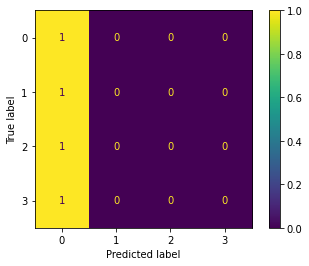

In [15]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt 
from sklearn.metrics import plot_confusion_matrix

#clf = LogisticRegression(C = 0.1, penalty = 'l2',solver='liblinear',class_weight={0: 1,1: 2,2: 3,3: 10})
#clf = LogisticRegression(C = 0.1, penalty = 'l2',solver='liblinear',class_weight={0: best_vec[0],1: best_vec[1],2: best_vec[2],3: best_vec[3]})

clf = LogisticRegression(C = 1, penalty = 'l2',solver='liblinear')


clf = clf.fit(X, Y)
#Y_h=clf.predict_proba(X)
Y_h_test=clf.predict_proba(X_test)

plot_confusion_matrix(clf, X_test, Y_test,normalize='true')  # doctest: +SKIP
plt.show() 

####*Tree* based models

We chose tree based models because they are suitable for imbalanced datasets.  They can handle large number of predictors with builtin regularization. They are suitable for tabular data. Further, they provide interpretable non-linear models for multi-class classfication.

Decision Tree provide a classifiation accuracy of 0.72 and a competition score of around 15. The results are similar with oversampling. The better accuracy  shows that the underlying model is non-linear and we may obtain better results with a more powerful method. The worse competitsion score against the linear model and the mode, is due to the pruning tree function. Tree use accuracy based pruning which is not the same as corss entropy.

On the other hand, we extracted *numerical variables that capture the current number of people accepted. They could be used to show the capacity of each center* and there is a great chance that linear combination of these variables play a significant role in the human decision process. But ***decisions tree fails to handle aditive functions***, and we think that one could obtain better results by Tree Based Models that can handle additive functions.



Here we chose the GBM, XGboost and RandomForest. A non-tuned version of any of the mentioned models, without any parameter tuning produce an accuracy around 0.79. However this is not the case for the competition score. The boosting based methods minimize crosentroy, thus obtain more accurate posterior probabilies whereas random forest focuses on accuracy metric. The competiton socre for simple non-tuned versions of GBM and XGboost are similar 3.3 and 3.1 respectively. 

When it comes to Random Forest, a model RF1 with 50 estimator provide a competition score of 1.4 and its variant RF2 with 100 estimator get competition  score of 0.48 while their corresponding accuracy are approximately 0.79.


A Random forest model RF1 (50 estimator) is then rebuilt using SOMTE oversampled datasets (Xo,Yo). The mentioned model (RF1 SMOTE) provide in a largly better competition score of 0.8. By repeating the experiment with RF2, we have a competition score of 0.58 for RF2 SMOTE.

In Boosting methods, the oversampling worsen result and produce a competition score around 3.7. It could be explained by the fact that SMOTE fails to capture the non-linear manifold of the data and so by modifying the prior distribution of class 2 and 3, it affect their respective psoteriors which result in a worse crossentropy and so a higher competition score. Nevertheless, if oversampling provide such intersting results for RFV1 and the same negative impact for Boosting neighter, so we may build a stronger oversampler with a Variational AutoEncoder. This could be a direction for future work.

Finnaly, the shape package works with XGboost so I chose XGboost over GBM for the rest of code.

 

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn import  tree

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


#clf_tree=RandomForestClassifier(n_estimators=100)
#clf_tree=RandomForestClassifier(n_estimators=50)
#clf_tree = GradientBoostingClassifier(n_estimators=100,  learning_rate=1.0,
#                                      max_depth=1, random_state=0,)
clf_tree = xgboost.XGBClassifier(objective='multi:softprob',
                                max_depth=6,
                                 verbose=True)
#clf_tree = tree.DecisionTreeClassifier()

clf_tree.fit(X, Y)

#clf_tree.fit(Xo, Yo)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbose=True, verbosity=1)

##### Looking At results
Look at confusion matrices and see how the detection rate and precision rate of classes are in a decreasing order. 
The idea is to first find the best approximation of conditional posterior probabilities and then multiply them by the respective loss function to find the lowest risk. This multipication is just the simplelest application of statistical decision theory.

When focusing on probability priors [0.49, 0.34, 0.15, 0.01], defined as trains_props in code,  and their corresponding loss functions, we can see that the prior risk of class 1 and 2, respectively 0.34*10, 0.15*100 would be the most important ones. Therefore we need a ordered detection priority in  classes (2, 1,3 and 0 ) in a tradoff with smaller value of precisions on class 0,3,1 and 2. 
The precisions don't have the same importance because they a false positive has the same cost in all class whereas a False Negative cost for class 3 is 1000 times a False negative of class 0. 


Further by looking at the precision confusion matrix, we can see that the XGbost function has more dificulties when distinguising some borders than others. For class 2, the hardest border is with class 1 and for class 1 the hardest is with class 0.


In [17]:
train_props

array([0.48928167, 0.34309585, 0.15676561, 0.01085688])

Look at detection


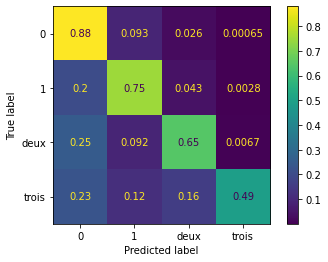

Look at precision


<Figure size 432x288 with 0 Axes>

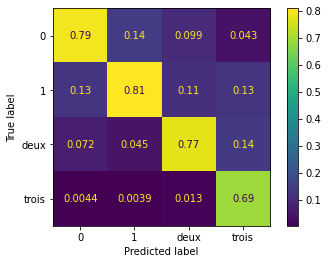

In [18]:


Y_h_test=clf_tree.predict_proba(X_test)

print('Look at detection')
t_pred = np.argmax(Y_h_test,axis=1)
display_labels=['0','1','deux','trois'];
cm=confusion_matrix(Y_test,t_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp = disp.plot()


plt.show()


print('Look at precision')
plt.figure()

display_labels=['0','1','deux','trois'];
cm=confusion_matrix(Y_test,t_pred,normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp = disp.plot()


plt.show()



In [19]:
from itertools import compress
from sklearn import tree
from  sklearn.metrics import log_loss
from sklearn.metrics import *

def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true,labels=[0,1,2,3])
    #return log_loss(y_true, y_pred,labels=[0,1,2,3])


t=Y_h_test.copy()
Gt=Y_test.copy()

t_pred = np.argmax(t,axis=1)


random_preds=np.random.uniform(low=0.3,high=0.5, size=(len(Gt), 4))

### mode of each distribution
random_preds[:,:]=train_props

#t=t*train_props
t[:,:]=train_props

#t[:, [0,1,2]]=Y_h_test[:,[0,1,2]]
t[:, [0,1,2,3]]=Y_h_test[:,[0,1,2,3]]


t=t.astype(np.float128)

#weight_vec=[1,1,1,1]
### multiply posterior proabability with loss function
weight_vec=[1,10,100,1000]
t_vals=np.apply_along_axis(lambda k:(k*weight_vec)/np.sum(k*weight_vec),1,t)  
t_vals[np.isnan(t_vals)]=1
random_vals=np.apply_along_axis(lambda k:(k*weight_vec)/np.sum(k*weight_vec),1,random_preds)  



print(f'Posterior competition risk  : {competition_scorer(Gt, t_vals)} \n')

print(f'Prior competition risk  : {competition_scorer(Gt, random_vals)}')

print('\n-------------- log_loss ---- \n ')
print(f'Posterior cross entropy  : {log_loss(Gt, t)} \n')

print(f'Prior cross entropy  : {log_loss(Gt, random_preds)}')



#############################

print('\n----------Accuracy -----------------')

print(f' Posterior accuracy   : {accuracy_score(Gt, np.argmax(t,axis=1))}')

print(f' Prior accuracy   : {accuracy_score(Gt, np.argmax(random_preds,axis=1))}')




Posterior competition risk  : 0.3160685275304491 

Prior competition risk  : 1.0239905323872114

-------------- log_loss ---- 
 
Posterior cross entropy  : 0.47974268400083236 

Prior cross entropy  : 1.0534855783636963

----------Accuracy -----------------
 Posterior accuracy   : 0.7953751595351649
 Prior accuracy   : 0.4903775105797004


In [21]:
!pip install shap

     |████████████████████████████████| 327kB 5.5MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463924 sha256=f0fe29336c04d49aa58a671f947ad9fbf0d0830d7986eef8e219557ecf71cd49
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


#### Model interpretation

##### Feature Importance
Here we look at how globally each variable affects the multi-class prediction problem.
Note that since this is a multiclass-prediction with a conventional crossentropy loss, the feature importance show the mean effect of each independent variable in reducing the mentioned loss function, averaged for the 4 classes.

We expect that the most imoportant variables should be those employed for detecting majority classes ,0 and 1.


nbCurrRejectCard ,column 16  Score: 0.03237
nbCurrAdmited1Day ,column 18  Score: 0.02699
nbCurrAdmited2Day ,column 19  Score: 0.03872
grNbAdmited1Day ,column 21  Score: 0.04240
grNbAdmited2Day ,column 22  Score: 0.02193
grNbAdmitedDay ,column 24  Score: 0.09006
grNbRejectCard ,column 26  Score: 0.02686
grLastAdmitType2_converted ,column 29  Score: 0.06871
grLastAdmitTypeNeg_converted ,column 38  Score: 0.04592
grLastAdmitType1_converted ,column 44  Score: 0.24228
housing_situation_label_emergency structure ,column 62  Score: 0.08033
housing_situation_label_hotel paid by the emergency centre ,column 64  Score: 0.09272


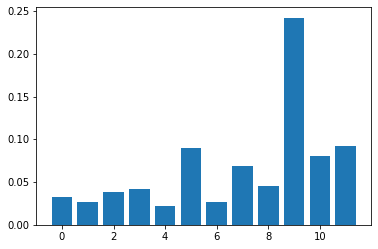

In [41]:
importance = clf_tree.feature_importances_
# summarize feature importance
import matplotlib.pyplot as plt


for i,v in enumerate(importance):
  if(v>0.02 ):
	  print(X.columns[i] ,',column %d  Score: %.5f' % (i,v))
# plot feature importance

v=importance[importance>0.02]

plt.bar([x for x in range(len(v))], v)
plt.show()


It is interesting to note that the most important variables is grLastAdmitType1_converted which show the differnce in days with the last time that the person was admited for one night. The second most important variable is grNbAdmitedDay, which is the number total that the group has been admited till now. 
Another intersting variable is grLastAdmitType2_converted which is the differnce in days with the last time that the person was admited for 2 nights.

The aforementioned variables are the one reflecting the history of the indicidual and the decision of the structure to wether accept them for 0,1 nights.

Since the top classes are 0 and 1 , the aforementioned  variables are related to the choice of the agent to accept or reject them. Note that if a person has been admited for two nights it make sense to thinkk that he could be accepted again. While looking at relative importance, it worths to see whether this variable has an impact on both class 1 and 2 !   

By looking at varaibales we cluster them in three set:
1.  The hsitory of the group,  when and what decision did the center took the 
last time. 

2. Already in emergency structure

3.  How are we working allocating today: 
   * number of rejected till now ,nbCurrRejectCard  0.03237

   * number of accepted peoples till now for 2 days  nbCurrAdmited2Day 0.03872
   * number of accepted peoples till now for 1 days nbCurrAdmited1Day 0.02699



It shows a temporal classification model which reflects a sensible human behaviour for resource allocation regarding emergency needs.

nbCurrRejectCard ,column 16  Score: 0.03237
nbCurrAdmited1Day ,column 18  Score: 0.02699
nbCurrAdmited2Day ,column 19  Score: 0.03872
grNbAdmited1Day ,column 21  Score: 0.04240
grNbAdmited2Day ,column 22  Score: 0.02193
grNbAdmitedDay ,column 24  Score: 0.09006
grNbRejectCard ,column 26  Score: 0.02686
grLastAdmitType2_converted ,column 29  Score: 0.06871
grLastAdmitTypeNeg_converted ,column 38  Score: 0.04592
grLastAdmitType1_converted ,column 44  Score: 0.24228
housing_situation_label_emergency structure ,column 62  Score: 0.08033
housing_situation_label_hotel paid by the emergency centre ,column 64  Score: 0.09272


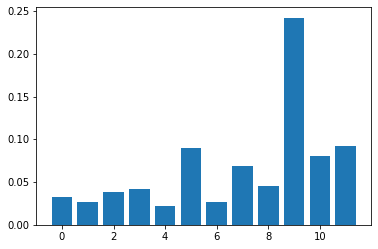

In [39]:
importance = clf_tree.feature_importances_
# summarize feature importance
import matplotlib.pyplot as plt


for i,v in enumerate(importance):
  if(v>0.02 ):
	  print(X.columns[i] ,',column %d  Score: %.5f' % (i,v))
# plot feature importance

v=importance[importance>0.02]

plt.bar([x for x in range(len(v))], v)
plt.show()

#### SHAP model explainability

In [43]:
!pip install shap

#### Looking at SHAP

Here we will first look at relative impact of each variables.


By looking and relative variable impact using SHAP, it is intersting to note that the how the variable regarding the number of admited people till now for 1 2 or 3 nights are the most important to accept or reject a group.

In global importance, we obsereved that the variable grLastAdmitType2_converted  which is the differnce in days with the last time that the person was admited for 2 nights, was on average impactful. So, we questioned ourself about the hypothesis, whether the relative impact of the variable grLastAdmitType2_converted  would still be high on both class 1 and 2 ?   

We can see a counterintutif result that this variable has not a significatif merit for distinguishing any class. This is explained by the fact that it has strong interaction with other variables like grNbDayFromLastAdmit ( tells the difference in days from the last admission) and grNbAdmit2Day (number of the times that the group has been accepted for class 2). 


In [241]:
import shap

explainer = shap.TreeExplainer(clf_tree)
shap_values=explainer.shap_values(X_test)

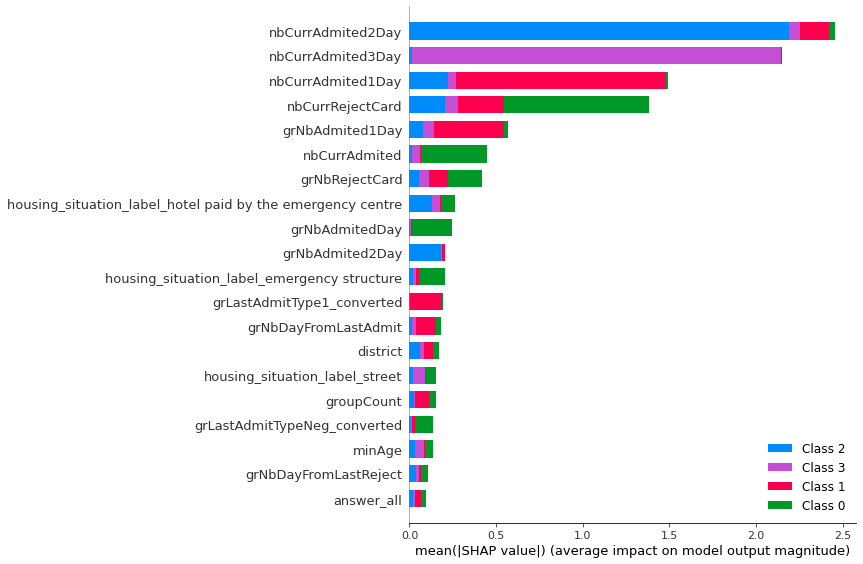

In [242]:

shap.initjs()
shap.summary_plot(shap_values, X_test)


##### Local interpretation

Here we use lime to see local explainablity of the model. Lime explains individual predictions by reflecting the behavior of the model in the neigborhood of the instance that we predict. This is called "local fidelity".

In [243]:
testing_class=1
obsInd_withinClass=30
row_ind = tIndsDic[testing_class][obsInd_withinClass]

shap.initjs()
shap.force_plot(explainer.expected_value[testing_class], shap_values[testing_class][row,:], X_test.iloc[row,:])

##### LIME for Local Explainability

In [50]:
!pip install lime

     |████████████████████████████████| 276kB 5.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=7ec38d285f7782c37a3d87094c9b0bf580a6db11931e56fcaeb199284f133ba2
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [224]:
def wrapped_XGB_predict2(data_x):
    v=data_x
    transposerow = pd.DataFrame(v)
    if(v.shape[0]==1):
      transposerow = pd.DataFrame(v).T
    transposerow.columns=X_test.columns
    clf_tree.predict_proba(transposerow)
    return clf_tree.predict_proba(transposerow)



(2, 4)

In [234]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X.to_numpy(), feature_names=X.columns, discretize_continuous=True)



In [237]:
idx = 15
datarow=X_test.iloc[idx,:].to_numpy()

In [239]:
exp = explainer.explain_instance(datarow, wrapped_XGB_predict2,num_features=5, top_labels=4)

exp.show_in_notebook(show_table = True, show_all= False)

### 7- Extending Classification Model evaluation for XGboost


In [246]:
from itertools import compress


ind0=np.array(list(compress(range(len(Gt)),(Gt==0))))
ind1=np.array(list(compress(range(len(Gt)),(Gt==1))))
ind2=np.array(list(compress(range(len(Gt)),(Gt==2))))
ind3=np.array(list(compress(range(len(Gt)),(Gt==3))))

ind01=np.hstack((ind0,ind1))
ind23=np.hstack((ind2,ind3))
ind012=np.hstack((ind0,ind1,ind2))
ind013=np.hstack((ind0,ind1,ind3))
ind023=np.hstack((ind0,ind2,ind3))
ind123=np.hstack((ind1,ind2,ind3))


print(len(ind0),len(ind1),len(ind2),len(ind3))
print(len(ind01),len(ind23))
print(len(ind012))



29201 20478 9245 624
49679 9869
58924


#### Odd Class3/calss1
We see that some instance in class 1 for whom their posterior predicted odd of 3/1 is higher than those of class 3. 


[]

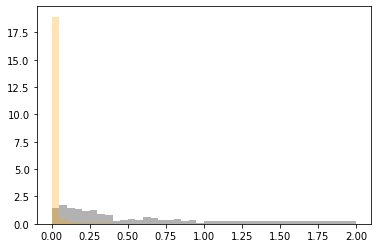

In [347]:
c=3
cnot=1

allodd=t[:,c]/t[:,cnot]
odd3=t[ind3,c]/t[ind3,cnot]

oddnot3=t[ind012,c]/t[ind012,cnot]
odd13=t[ind1,c]/t[ind1,cnot]


import matplotlib.pyplot as plt

#bins=None
bins=np.array(range(0,101,5))/100
bins=list(bins)+[2]

bb={}
bb={'density':True}

plt.hist(odd3,color='Black',alpha=0.3,bins=bins,**bb)

plt.hist(odd13,color='Orange',alpha=0.3,bins=bins,**bb)





plt.plot()

#### Odd Class0/calss1 
We see that there is a non-significant part of class 1 who is nor seperable from class 0. It means that we can try to use other models only for imporving the border of this two class.

[]

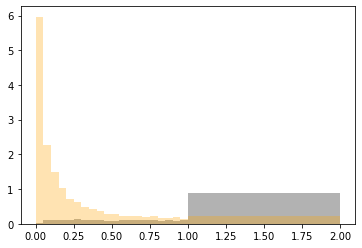

In [354]:
c=0
cnot=1

allodd=t[:,c]/t[:,cnot]
odd0=t[ind0,c]/t[ind0,cnot]

odd01=t[ind1,c]/t[ind1,cnot]


import matplotlib.pyplot as plt

bins=None

odd0[odd0>2]=2
odd01[odd01>2]=2

bins=np.array(range(0,101,5))/100
bins=list(bins)+[2]

bb={}
bb={'density':True}

plt.hist(odd0,color='Black',alpha=0.3,bins=bins,**bb)
plt.hist(odd01,color='Orange',alpha=0.3,bins=bins,**bb)





plt.plot()

In [ ]:

random_preds=np.random.uniform(low=0.3,high=0.5, size=(requests_train.shape[0], 4))

#random_preds[:,:]=[0.01,0.01,0.01,0.01]
random_preds[:,:]=best_vec

#random_preds[ind2,:]=[0.01,0.09,0.75,0.04]
#random_preds[ind3,:]=[0.02,0.24,0.04,0.7]

#random_preds[ind2,:]=[0.02,0.01,0.95,0.01]
#random_preds[ind3,:]=[0.02,0.01,0.01,0.95]

#random_preds[ind23,:]=[0.02,0.01,best_vec[2],best_vec[3]]


random_preds=random_preds[ind23,:]
V=Y[ind23]
#random_preds[ind0,:]=[0.08,0.72,0.1,0.1]
#random_preds[ind1,:]=[0.08,0.72,0.1,0.1]

print(f'random score 0 : {competition_scorer(V, random_preds)}')




random score 0 : 0.8143600832516227


### 0- Preliminary Data Analysis

#### Looking at data distribution

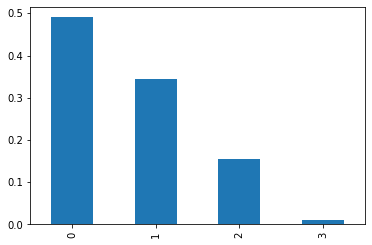

0    0.490378
1    0.343891
2    0.155253
3    0.010479
Name: granted_number_of_nights, dtype: float64


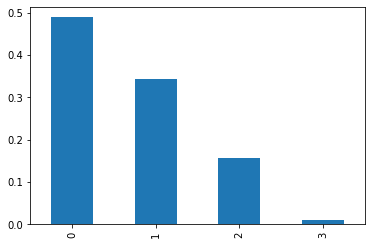

0    0.489282
1    0.343096
2    0.156766
3    0.010857
Name: granted_number_of_nights, dtype: float64


In [24]:
import matplotlib.pyplot as plt
plt.figure()
a=requests_test.granted_number_of_nights.value_counts(normalize=True)
a.plot(kind='bar')
plt.show()
print(a)
plt.figure()
b=requests_train.granted_number_of_nights.value_counts(normalize=True)
b.plot(kind='bar')
plt.show()
print(b)

In [25]:
df=requests_train.groupby(['group_type','granted_number_of_nights'])['group_type'].count()
v=df.unstack()
v.columns=['0','1','2','3']


print(v)

print('Distribution of number of nights within groups/individuals')
print(v.apply(lambda k: k/np.sum(k),axis=1))


print('------')
print('Distribution of group/individuals per number of nights')
print(v.apply(lambda k: k/np.sum(k),axis=0))

print('------')


## one could observe that: 
### 1- group is not independent of class
### based on number of observations, no need to check chi-square test
### 2-The marginal rejection rate is greater fro groups than for individuals
### etc.


                0      1      2     3
group_type                           
group       35620  15277  14766  1475
individual  80922  66445  22574  1111
Distribution of number of nights within groups/individuals
                   0         1         2         3
group_type                                        
group       0.530549  0.227546  0.219935  0.021970
individual  0.473084  0.388449  0.131972  0.006495
------
Distribution of group/individuals per number of nights
                   0         1         2         3
group_type                                        
group       0.305641  0.186939  0.395447  0.570379
individual  0.694359  0.813061  0.604553  0.429621
------


#### See Daily request rejection

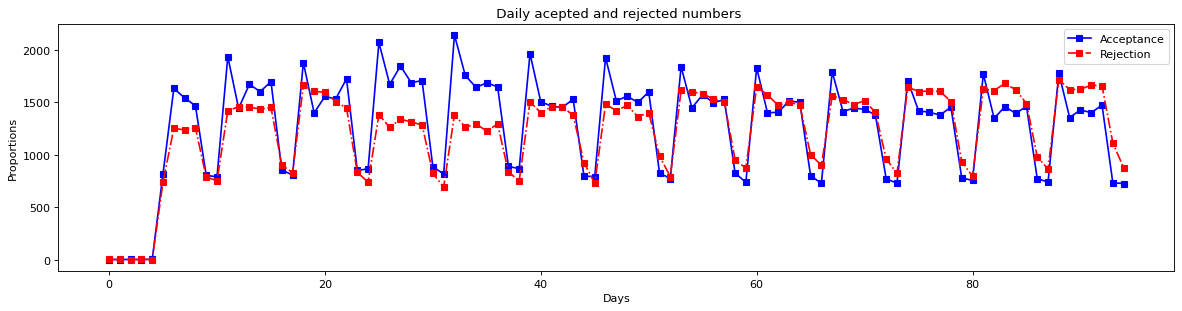

In [32]:
vall=requests_train.groupby(['answer_all'])['granted_number_of_nights'].sum()
vall=vall.sort_index()

vpos0=requests_train[requests_train.granted_number_of_nights==0].groupby(['answer_all'])['granted_number_of_nights'].count()
vpos=requests_train[requests_train.granted_number_of_nights>0].groupby(['answer_all'])['granted_number_of_nights'].count()


all_ndays=set(vpos0.index).symmetric_difference(  set(vpos.index))
all_days=set(set(vall.index))
base=pd.Series(index=list(all_days),data=0);

vpos=base.add(vpos,fill_value=0)
vpos0=base.add(vpos0,fill_value=0)

vpos=vpos.sort_index()
vpos0=vpos0.sort_index()

valsp=vpos.values[:]
valsp0=vpos0.values[:]

import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(211)
ax1.set_ylabel('Proportions')
ax1.set_xlabel('Days')
ax1.set_title(' Daily acepted and rejected numbers')


plt.plot(valsp,"-",marker='s',color='blue')

plt.plot(valsp0,'-.',marker='s',color='red')

#plt.plot(np.ones_like(rej_prop)*np.mean(rej_prop),':',color='green')

ax1.legend(['Acceptance','Rejection'])

plt.show()

#print(len(valsp),len(valsp0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


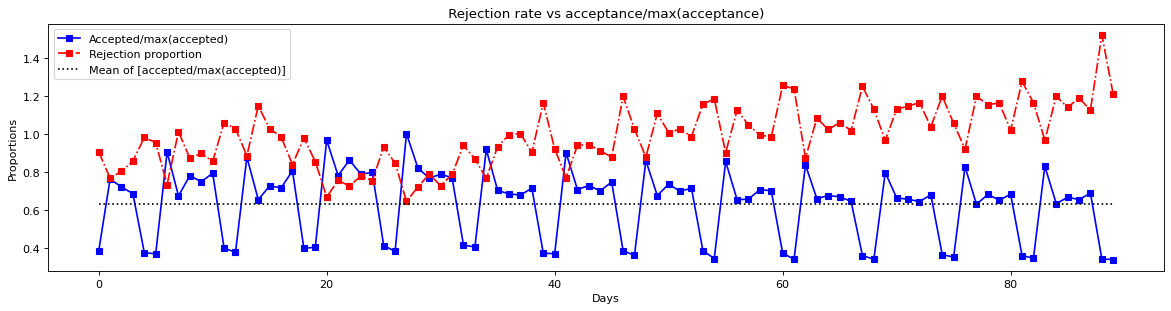

In [27]:
vall=requests_train.groupby(['answer_all'])['granted_number_of_nights'].sum()
vall=vall.sort_index()

vpos0=requests_train[requests_train.granted_number_of_nights==0].groupby(['answer_all'])['granted_number_of_nights'].count()
vpos=requests_train[requests_train.granted_number_of_nights>0].groupby(['answer_all'])['granted_number_of_nights'].count()


all_ndays=set(vpos0.index).symmetric_difference(  set(vpos.index))
all_days=set(set(vall.index))
base=pd.Series(index=list(all_days),data=0);

vpos=base.add(vpos,fill_value=0)
vpos0=base.add(vpos0,fill_value=0)

vpos=vpos.sort_index()
vpos0=vpos0.sort_index()


valsp=vpos.values[-0:]
valsp0=vpos0.values[-0:]


###############
accept=valsp
refus=valsp0
max_accept=np.max(accept)

demande=(refus+accept)
restant=max_accept-accept

rej_prop=(refus/accept)[-0:]

accept_prop=accept/max_accept

restant_prop=restant/max_accept

rej_prop=rej_prop[5:]
accept_prop=accept_prop[5:]
#rej_prop-=np.mean(rej_prop)
#accept_prop-=np.mean(accept_prop)

import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(211)
ax1.set_ylabel('Proportions')
ax1.set_xlabel('Days')
ax1.set_title(' Rejection rate vs acceptance/max(acceptance) ')

plt.plot(accept_prop,"-",marker='s',color='blue')

plt.plot(rej_prop,'-.',marker='s',color='red')

plt.plot(np.ones_like(accept_prop)* np.mean(accept_prop),':',color='black')

ax1.legend(['Accepted/max(accepted)','Rejection proportion','Mean of [accepted/max(accepted)]'])

plt.show()
#print(len(valsp),len(valsp0))

#### See request rejection based on groups

In [ ]:
#### group by to see if there is any group with zero rejection

gb3=requests_train[['group_id','granted_number_of_nights']].groupby(
    ['group_id','granted_number_of_nights']).agg( count_times=('granted_number_of_nights','sum'))

gb3.sort_index(inplace=True)
gb3.reset_index( inplace=True)


df_tm=pd.DataFrame({
    'group_id': pd.Categorical( requests_train.group_id.to_list()),
    'granted_number_of_nights': pd.Categorical(  requests_train.granted_number_of_nights.to_list()),
    'v': 0
    })

gb4=df_tm.groupby(['group_id','granted_number_of_nights'])['v'].count()

tmp_all_nights=np.sum(gb4.index.to_frame().iloc[:,1].values.astype(int) *  gb4.values )

assert(sum(requests_train.granted_number_of_nights)==tmp_all_nights)

a=gb4.reset_index().pivot(index='group_id',columns='granted_number_of_nights', values='v')
a.head()


granted_number_of_nights,0,1,2,3
group_id,,,,
00038a58e1ee9a08a7f72423fceaa40b,23,0,5,0
0004d10d019042c18e1c5aa4e0d8bd4a,2,0,0,0
00050dce88b5ccb408f0e3b260c7306e,1,0,0,0
0005af291d008f42966a08a2cb3cc593,2,0,0,0
0005b28cdd2d812435cef68ad4a6431e,0,0,0,1


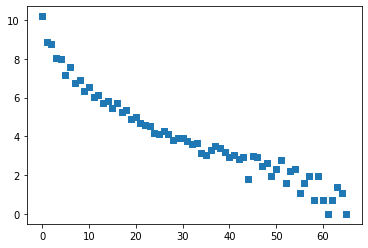

In [ ]:
### see how groups get attention
### log(number of group) is the y axis
### sum of passed nights is the x axis
gb3.reset_index(level=0, inplace=True)

gb3.head(5)

import matplotlib.pyplot as plt
#plt.figure()
plt.scatter(x=v.index,y=np.log(v.values),marker='s')
plt.show()

In [ ]:
#### looking how diferrent groups are 

gb=requests_train[['group_id','granted_number_of_nights']].groupby('group_id').agg( sum_nights=('granted_number_of_nights','sum'))

print(gb.shape)
gb.sort_values(by='sum_nights',inplace=True)
v=gb.sum_nights.groupby(gb.sum_nights).count().sort_index()
assert (sum(v.index*v.values) == sum(requests_train.granted_number_of_nights))

print('Group counts ordered by number of nights passed in the center ')
print(v.head(10))
print('******* We can see that some groups are getting more attentions')


(56851, 1)
Group counts ordered by number of nights passed in the center 
sum_nights
0    26873
1     7231
2     6331
3     3079
4     2913
5     1302
6     1997
7      841
8     1024
9      570
Name: sum_nights, dtype: int64
******* We can see that some groups are getting more attentions


In [ ]:
#### test different hypothesis 

c=a.to_numpy() 

print(' Total number of group : ',c.shape[0],'\n')

# a group with rejection but also accepted in all 3 situations
v=(c[:,0] >0) & (c[:,1] >=0) & (c[:,2] >=0) & (c[:,3] >=0)
print('Group number per number of acceptance   \n for ex : 26873 groups accepted 0 times \n ')
print(pd.Series(c[v,1:].sum(axis=1) ).value_counts().sort_index()[:12])



#v=np.logical_and((c[:,0] >0) , (c[:,1] >0),(c[:,2] >0),(c[:,2] >0))
# the below is a group with zero rejection
v=(c[:,0] ==0) & (c[:,1] >0) & (c[:,2] >0) & (c[:,3] >0)

print('\n\nGroup who just got accepted \n for ex : 37 groups accepted 4 times \n ')
print(pd.Series(c[v,:].sum(axis=1) ).value_counts().sort_index()[:10])

print(' Total number of only accepted : ',pd.Series(pd.Series(c[v,:].sum(axis=1) )).value_counts().sum())


# a group with just rejections
v=(c[:,0] >0) & (c[:,1] ==0) & (c[:,2] ==0) & (c[:,3] ==0)

print('\n\nGroup who just got rejected \n for ex : 3876 groups rejected 2 times \n ')
print(pd.Series(c[v,0 ]).value_counts().sort_index()[:10])

print(' Total number of only rejected seen above : ',pd.Series(c[v,0 ]).value_counts().sum())



#c.shape

 Total number of group :  56851 

Group number per number of acceptance   
 for ex : 26873 groups accepted 0 times 
 
0     26873
1      4129
2      2037
3      1317
4       965
5       785
6       574
7       425
8       380
9       292
10      251
11      189
dtype: int64


Group who just got accepted 
 for ex : 37 groups accepted 4 times 
 
3     34
4     37
5     28
6     17
7     11
8      8
9      9
10     6
11     2
13     2
dtype: int64
 Total number of only accepted :  160


Group who just got rejected 
 for ex : 3876 groups rejected 2 times 
 
1     17594
2      3876
3      1755
4       994
5       570
6       422
7       329
8       213
9       179
10      149
dtype: int64
 Total number of only rejected seen above :  26873
